In [1]:
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def load_results(file_path):
    """Load results from JSON file."""
    with open(file_path, 'r') as f:
        return json.load(f)

In [3]:
def calculate_accuracy(predictions, ground_truths):
    """Calculate accuracy between predictions and ground truths."""
    # Convert Series to lists to avoid pandas Series ambiguity
    if hasattr(predictions, 'tolist'):
        predictions = predictions.tolist()
    if hasattr(ground_truths, 'tolist'):
        ground_truths = ground_truths.tolist()
    
    # Calculate accuracy
    correct = sum(1 for p, g in zip(predictions, ground_truths) if str(p) == str(g))
    return correct / len(predictions) if predictions else 0

In [4]:
def calculate_error_metrics(predictions, ground_truths, category=None):
    """
    Calculate MAE, MSE, and RMSE between predictions and ground truths.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        category: Optional category name for the analysis
        
    Returns:
        Dictionary containing MAE, MSE, and RMSE
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    # Calculate differences
    differences = [abs(p - t) for p, t in zip(preds, truths)]
    
    # Calculate metrics
    mae = sum(differences) / len(differences)
    mse = sum(d * d for d in differences) / len(differences)
    rmse = mse ** 0.5
    
    result = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'sample_size': len(differences)
    }
    
    if category:
        result['category'] = category
        
    return result

In [5]:
def calculate_off_by_n_accuracy(predictions, ground_truths, n=1):
    """
    Calculate accuracy within n counts of the ground truth.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        n: Maximum allowed difference (default=1)
        
    Returns:
        Dictionary containing accuracy for each tolerance level up to n
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    results = {}
    # Cumulative accuracies
    for tolerance in range(n + 1):
        correct = sum(1 for p, t in zip(preds, truths) if abs(p - t) <= tolerance)
        accuracy = correct / len(preds)
        results[f'off_by_{tolerance}'] = accuracy

    # Individual accuracies
    for tolerance in range(n + 1):
        if tolerance == 0:
            results[f'exactly_{tolerance}'] = results[f'off_by_{tolerance}']
        else:
            # Count only predictions that are exactly off by tolerance
            exact_count = sum(1 for p, t in zip(preds, truths) if abs(p - t) == tolerance)
            results[f'exactly_{tolerance}'] = exact_count / len(preds)

    return results

In [6]:
def analyze_error_distribution(predictions, ground_truths):
    """
    Analyze the distribution of counting errors.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        
    Returns:
        Dictionary containing error distribution statistics
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    # Calculate errors
    errors = [p - t for p, t in zip(preds, truths)]
    
    # Calculate statistics
    mean_error = sum(errors) / len(errors)
    median_error = sorted(errors)[len(errors) // 2]
    
    # Count over/under predictions
    over_count = sum(1 for e in errors if e > 0)
    under_count = sum(1 for e in errors if e < 0)
    exact_count = sum(1 for e in errors if e == 0)
    
    return {
        'mean_error': mean_error,
        'median_error': median_error,
        'over_count': over_count,
        'under_count': under_count,
        'exact_count': exact_count,
        'error_distribution': errors
    }

In [7]:
def calculate_random_baseline(min_count=0, max_count=10, n=2):
    """
    Calculate random baseline probabilities for off-by-n accuracy.
    
    Args:
        min_count: Minimum possible count (default=0)
        max_count: Maximum possible count (default=10)
        n: Maximum allowed difference for off-by-n (default=2)
        
    Returns:
        Dictionary containing baseline probabilities for each tolerance level
    """
    total_possible_counts = max_count - min_count + 1
    baseline_probs = {}
    
    # Calculate for each tolerance level
    for tolerance in range(n + 1):
        # For each possible count, calculate how many other counts would be considered correct
        correct_counts = 0
        for true_count in range(min_count, max_count + 1):
            # Count how many predictions would be considered correct for this true count
            for pred_count in range(min_count, max_count + 1):
                if abs(pred_count - true_count) <= tolerance:
                    correct_counts += 1
        
        # Calculate probability
        # For each true count, we have total_possible_counts possible predictions
        total_possible_predictions = total_possible_counts * total_possible_counts
        probability = correct_counts / total_possible_predictions
        
        baseline_probs[f'off_by_{tolerance}'] = probability
        
        # Calculate individual probabilities
        for tolerance in range(n + 1):
            if tolerance == 0:
                baseline_probs[f'exactly_{tolerance}'] = baseline_probs[f'off_by_{tolerance}']
            else:
                # Count only predictions that are exactly off by tolerance
                exact_counts = 0
                for true_count in range(min_count, max_count + 1):
                    for pred_count in range(min_count, max_count + 1):
                        if abs(pred_count - true_count) == tolerance:
                            exact_counts += 1
                
                baseline_probs[f'exactly_{tolerance}'] = exact_counts / (total_possible_counts * total_possible_counts)
    
    return baseline_probs

In [8]:
def analyze_results(results_file, model_name):
    """Analyze results across different dimensions with additional metrics."""
    results = load_results(results_file)
    
    # Convert results to DataFrame for easier analysis
    df = pd.DataFrame(results)
    
    # 1. Overall Accuracy
    overall_accuracy = calculate_accuracy(df['model_answer'], df['ground_truth'])
    print(f"\n{model_name} Overall Accuracy: {overall_accuracy:.2%}")
    
    # 2. Overall Error Metrics
    overall_error_metrics = calculate_error_metrics(df['model_answer'], df['ground_truth'], 'Overall')
    print("\nOverall Error Metrics:")
    for metric, value in overall_error_metrics.items():
        if metric != 'category' and metric != 'sample_size':
            print(f"{metric}: {value:.2f}")
    
    # 3. Off-by-N Accuracy (Overall)
    off_by_n = calculate_off_by_n_accuracy(df['model_answer'], df['ground_truth'], n=2)
    print("\nOverall Off-by-N Accuracy:")
    for n, acc in off_by_n.items():
        print(f"{n}: {acc:.2%}")
    
    # 4. Error Distribution (Overall)
    error_dist = analyze_error_distribution(df['model_answer'], df['ground_truth'])
    print("\nOverall Error Distribution:")
    print(f"Mean Error: {error_dist['mean_error']:.2f}")
    print(f"Median Error: {error_dist['median_error']:.2f}")
    print(f"Over-counts: {error_dist['over_count']}")
    print(f"Under-counts: {error_dist['under_count']}")
    print(f"Exact counts: {error_dist['exact_count']}")
    
    # 5. Question-type Analysis
    df['question_type'] = df.apply(lambda x: int(x['question_id'].replace('Q', '')), axis=1)
    df['question_category'] = df['question_type'].map({
        1: 'Direct Recognition',
        2: 'Property Inference',
        3: 'Counterfactual'
    })

    question_accuracies = df.groupby('question_category').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Question Type:")
    for q_type, acc in question_accuracies.items():
        print(f"{q_type}: {acc:.2%}")
    
    # 6. Image Type Analysis
    image_type_accuracies = df.groupby('image_type').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Image Type:")
    for img_type, acc in image_type_accuracies.items():
        print(f"{img_type}: {acc:.2%}")

    # 7. Property Category Analysis
    property_accuracies = df.groupby('property_category').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Property Category:")
    for prop, acc in property_accuracies.items():
        print(f"{prop}: {acc:.2%}")


    # Calculate error metrics for each question category
    question_error_metrics = {}
    for q_type in df['question_category'].unique():
        q_df = df[df['question_category'] == q_type]
        question_error_metrics[q_type] = calculate_error_metrics(
            q_df['model_answer'], 
            q_df['ground_truth'],
            q_type
        )
    
    print("\nError Metrics by Question Type:")
    for q_type, metrics in question_error_metrics.items():
        print(f"\n{q_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")
    
    # Similar analysis for image types and property categories
    image_error_metrics = {}
    for i_type in df['image_type'].unique():
        i_df = df[df['image_type'] == i_type]
        image_error_metrics[i_type] = calculate_error_metrics(
            i_df['model_answer'],
            i_df['ground_truth'],
            i_type
        )
    
    print("\nError Metrics by Image Type:")
    for i_type, metrics in image_error_metrics.items():
        print(f"\n{i_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")


    property_error_metrics = {}
    for p_type in df['property_category'].unique():
        p_df = df[df['property_category'] == p_type]
        property_error_metrics[p_type] = calculate_error_metrics(
            p_df['model_answer'],
            p_df['ground_truth'],
            p_type
        )
    
    print("\nError Metrics by Property caterogry:")
    for p_type, metrics in property_error_metrics.items():
        print(f"\n{p_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")
    
    return {
        'overall': overall_accuracy,
        'overall_error_metrics': overall_error_metrics,
        'question_error_metrics': question_error_metrics,
        'off_by_n': off_by_n,
        'error_distribution': error_dist,
        'question_type': question_accuracies,
        'image_type': image_type_accuracies,
        'property': property_accuracies,
        'df': df
    }

In [9]:
def plot_results(analysis_results, model_name):
    """Create visualizations for the results."""
    # Use a simple style that's guaranteed to work
    plt.style.use('default')
    
    # Set color scheme manually
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Question Type Accuracy Plot
    question_acc = analysis_results['question_type']
    bars1 = question_acc.plot(kind='bar', ax=ax1, color=colors)
    ax1.set_title(f'{model_name}: Accuracy by Question Type', pad=20)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for i, v in enumerate(question_acc):
        ax1.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')
    
    # 2. Image Type Accuracy Plot
    image_acc = analysis_results['image_type']
    bars2 = image_acc.plot(kind='bar', ax=ax2, color=colors)
    ax2.set_title(f'{model_name}: Accuracy by Image Type', pad=20)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    # Add value labels on top of bars
    for i, v in enumerate(image_acc):
        ax2.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'{model_name}_analysis.png', bbox_inches='tight', dpi=300)
    plt.close()

In [10]:
# def compare_models(model_results_dict):
#     """Compare results across different models."""
#     comparison_df = pd.DataFrame({
#         model: {
#             'Overall Accuracy': results['overall'],
#             'Direct Recognition': results['question_type']['Direct Recognition'],
#             'Property Inference': results['question_type']['Property Inference'],
#             'Counterfactual': results['question_type']['Counterfactual']
#         }
#         for model, results in model_results_dict.items()
#     }).T
    
#     # Format the DataFrame to display percentages with two decimal places
#     formatted_df = comparison_df.applymap(lambda x: f"{x * 100:.2f}%")

#     print("\nModel Comparison:")
#     print(formatted_df.to_string())
    
#     # Plot model comparison
#     plt.figure(figsize=(12, 6))
#     comparison_df.plot(kind='bar')
#     plt.title('Model Comparison Across Question Types')
#     plt.xlabel('Models')
#     plt.ylabel('Accuracy')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.savefig('model_comparison.png', bbox_inches='tight', dpi=300)
#     plt.close()

In [11]:
def compare_models_extended(model_results_dict):
    """Compare results across different models for question types, image types, and property categories."""
    # Use default style
    plt.style.use('default')
    
    # Create three DataFrames - one for each category type
    question_df = pd.DataFrame({
        model: {
            'Overall Accuracy': results['overall'],
            'Direct Recognition': results['question_type']['Direct Recognition'],
            'Property Inference': results['question_type']['Property Inference'],
            'Counterfactual': results['question_type']['Counterfactual']
        }
        for model, results in model_results_dict.items()
    }).T

    image_df = pd.DataFrame({
        model: {
            'REAL': results['image_type']['REAL'],
            'ANIMATED': results['image_type']['ANIMATED'],
            'AI_GENERATED': results['image_type']['AI_GENERATED']
        }
        for model, results in model_results_dict.items()
    }).T

    # Create property category DataFrame
    property_df = pd.DataFrame({
        model: {
            # 'functional/relational': results['property']['functional/relational'],
            'physical': results['property']['physical'],
            'taxonomic': results['property']['taxonomic'],
            'functional': results['property']['functional'],
            'relational': results['property']['relational'],
            # 'taxonomic/relational': results['property']['taxonomic/relational']
        }
        for model, results in model_results_dict.items()
    }).T
    
    # Format DataFrames to display percentages
    formatted_question_df = question_df.applymap(lambda x: f"{x * 100:.2f}%")
    formatted_image_df = image_df.applymap(lambda x: f"{x * 100:.2f}%")
    formatted_property_df = property_df.applymap(lambda x: f"{x * 100:.2f}%")

    # Print formatted results
    print("\nModel Comparison by Question Type:")
    print(formatted_question_df.to_string())
    print("\nModel Comparison by Image Type:")
    print(formatted_image_df.to_string())
    print("\nModel Comparison by Property Category:")
    print(formatted_property_df.to_string())
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    
    # Plot 1: Question Types
    question_df.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Model Comparison Across Question Types', pad=20)
    ax1.set_xlabel('')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels for question types
    # for i in range(len(question_df)):
    #     for j in range(len(question_df.columns)):
    #         value = question_df.iloc[i, j]
    #         ax1.text(i, value, f'{value:.1%}', 
    #                 ha='center', va='bottom')
    
    # Plot 2: Image Types
    image_df.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title('Model Comparison Across Image Types', pad=20)
    ax2.set_xlabel('')
    ax2.set_ylabel('Accuracy')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # # Add value labels for image types
    # for i in range(len(image_df)):
    #     for j in range(len(image_df.columns)):
    #         value = image_df.iloc[i, j]
    #         ax2.text(i, value, f'{value:.1%}', 
    #                 ha='center', va='bottom')

    # Plot 3: Property Categories
    property_df.plot(kind='bar', ax=ax3, width=0.8)
    ax3.set_title('Model Comparison Across Property Categories', pad=20)
    ax3.set_xlabel('Models')
    ax3.set_ylabel('Accuracy')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_xticklabels(ax3.get_xticklabels(), ha='right')
    ax3.grid(True, alpha=0.3)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # # Add value labels for property categories
    # for i in range(len(property_df)):
    #     for j in range(len(property_df.columns)):
    #         value = property_df.iloc[i, j]
    #         ax3.text(i, value, f'{value:.1%}', 
    #                 ha='center', va='bottom')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('model_comparison_extended.png', bbox_inches='tight', dpi=300)
    plt.close()

    return question_df, image_df, property_df

In [12]:
# Analyze results for each model
model_results = {}

# List of result files to analyze
result_files = {
    'BLIP2-OPT-2.7B': '/var/scratch/ave303/OP_bench/ORBIT_results/blip2-opt-2.7b_results.json',
    'BLIP2-OPT-6.7B': '/var/scratch/ave303/OP_bench/ORBIT_results/blip2-opt-6.7b_results.json',
    'FUYU-8B': '/var/scratch/ave303/OP_bench/ORBIT_results/fuyu_8b_results.json',
    # 'BLIP2-Flan-T5-XL': '/var/scratch/ave303/OP_bench/new_results/blip2-flan-t5-xl_results.json',
    'BLIP2-FLan-T5-XXL': '/var/scratch/ave303/OP_bench/ORBIT_results/blip2-flan-t5-xxl_results.json',  
    # 'SmolVLM2-2.2B-Instruct_fp16': '/var/scratch/ave303/OP_bench/results/smolVLM2_results_1.json',
    # 'InternVL2.5-4B-MPO_fp16': '/var/scratch/ave303/OP_bench/results/InternVL2.5_results_1.json',
    'Qwen2.5-VL-3B-Instruct': '/var/scratch/ave303/OP_bench/ORBIT_results/Qwen2.5-VL_3b_results.json',
    'Qwen2.5-VL-7B-Instruct': '/var/scratch/ave303/OP_bench/ORBIT_results/Qwen2.5-VL_7b_results.json',
    'Qwen2.5-VL-32B-Instruct': '/var/scratch/ave303/OP_bench/ORBIT_results/Qwen2.5-VL_32b_results.json',
    # 'Ristretto-3B_fp16': '/var/scratch/ave303/OP_bench/results/Ristretto_3b_results.json'
    # 'InternVL2.5-8B-MPO': '/var/scratch/ave303/OP_bench/new_results/InternVL2.5_results_8bMPO.json',
    'InternVL3-8B': '/var/scratch/ave303/OP_bench/ORBIT_results/InternVL3_results_8b.json',
    'InternVL3_14B': '/var/scratch/ave303/OP_bench/ORBIT_results/InternVL3_results_14b.json',
    # 'InternVL3_14B_1': '/var/scratch/ave303/OP_bench/new_results/InternVL3_results_14b_1.json',
    # 'Qwen2.5-VL-32B-Instruct_1': '/var/scratch/ave303/OP_bench/new_results/Qwen2.5-VL_32b_results_1.json',
    'Gemma3-27B-it': '/var/scratch/ave303/OP_bench/ORBIT_results/Gemma3_27b_results.json',
    'GPT-4o-mini': '/var/scratch/ave303/OP_bench/ORBIT_results/gpt-4o-mini_results.json',
    # 'Gemma3-27B-it_1': '/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results_1.json',
    # 'Gemini2_0Flash': '/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results.json',
    # 'Gemini2_0Flash_1': '/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results1.json',
    'Spacethinker-Qwen2.5-VL-3B-Instruct': '/var/scratch/ave303/OP_bench/ORBIT_results/Spacethinker-qwen2-5-vl-3b_results.json',
    # 'SpaceThinker-Qwen2.5-VL-3B-Instruct_1': '/var/scratch/ave303/OP_bench/new_results/Spacethinker-Qwen2.5-VL_3b_results_1.json',
    # 'SpaceQwen2.5-VL-3B-Instruct': '/var/scratch/ave303/OP_bench/new_results/SpaceQwen2.5-VL_3b_results.json'
    # Add other model result files here
}

for model_name, file_path in result_files.items():
    if Path(file_path).exists():
        print(f"\nAnalyzing {model_name}...")
        results = analyze_results(file_path, model_name)
        model_results[model_name] = results
        plot_results(results, model_name)

# Calculate random baseline
random_baseline = calculate_random_baseline()
print("\nRandom Baseline Probabilities:")
for n, prob in random_baseline.items():
    print(f"{n}: {prob:.2%}")

# Compare models if we have multiple results
if len(model_results) > 1:
    question_df, image_df, property_df = compare_models_extended(model_results)


Analyzing BLIP2-OPT-2.7B...

BLIP2-OPT-2.7B Overall Accuracy: 12.87%

Overall Error Metrics:
MAE: 2.84
MSE: 13.40
RMSE: 3.66

Overall Off-by-N Accuracy:
off_by_0: 12.87%
off_by_1: 35.28%
off_by_2: 53.52%
exactly_0: 12.87%
exactly_1: 22.41%
exactly_2: 18.24%

Overall Error Distribution:
Mean Error: -2.68
Median Error: -2.00
Over-counts: 63
Under-counts: 878
Exact counts: 139

Accuracy by Question Type:
Counterfactual: 14.72%
Direct Recognition: 10.83%
Property Inference: 13.06%

Accuracy by Image Type:
AI_GENERATED: 10.00%
ANIMATED: 19.44%
REAL: 9.17%

Accuracy by Property Category:
functional: 10.91%
physical: 11.48%
relational: 13.78%
taxonomic: 14.41%

Error Metrics by Question Type:

Direct Recognition:
MAE: 3.17
MSE: 15.82
RMSE: 3.98

Property Inference:
MAE: 2.67
MSE: 12.19
RMSE: 3.49

Counterfactual:
MAE: 2.66
MSE: 12.19
RMSE: 3.49

Error Metrics by Image Type:

REAL:
MAE: 3.47
MSE: 18.81
RMSE: 4.34

ANIMATED:
MAE: 2.13
MSE: 8.34
RMSE: 2.89

AI_GENERATED:
MAE: 2.91
MSE: 13.05
RM

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing BLIP2-OPT-6.7B...

BLIP2-OPT-6.7B Overall Accuracy: 16.67%

Overall Error Metrics:
MAE: 2.26
MSE: 9.34
RMSE: 3.06

Overall Off-by-N Accuracy:
off_by_0: 16.67%
off_by_1: 46.11%
off_by_2: 66.20%
exactly_0: 16.67%
exactly_1: 29.44%
exactly_2: 20.09%

Overall Error Distribution:
Mean Error: -1.56
Median Error: -1.00
Over-counts: 239
Under-counts: 661
Exact counts: 180

Accuracy by Question Type:
Counterfactual: 15.28%
Direct Recognition: 16.67%
Property Inference: 18.06%

Accuracy by Image Type:
AI_GENERATED: 14.72%
ANIMATED: 21.11%
REAL: 14.17%

Accuracy by Property Category:
functional: 14.09%
physical: 16.39%
relational: 19.08%
taxonomic: 16.52%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.43
MSE: 10.76
RMSE: 3.28

Property Inference:
MAE: 2.12
MSE: 8.52
RMSE: 2.92

Counterfactual:
MAE: 2.23
MSE: 8.73
RMSE: 2.95

Error Metrics by Image Type:

REAL:
MAE: 2.73
MSE: 12.97
RMSE: 3.60

ANIMATED:
MAE: 1.93
MSE: 7.26
RMSE: 2.69

AI_GENERATED:
MAE: 2.12
MSE: 7.78
RMSE

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing FUYU-8B...

FUYU-8B Overall Accuracy: 19.91%

Overall Error Metrics:
MAE: 1.97
MSE: 7.17
RMSE: 2.68

Overall Off-by-N Accuracy:
off_by_0: 19.91%
off_by_1: 49.72%
off_by_2: 71.20%
exactly_0: 19.91%
exactly_1: 29.81%
exactly_2: 21.48%

Overall Error Distribution:
Mean Error: -0.89
Median Error: -1.00
Over-counts: 302
Under-counts: 563
Exact counts: 215

Accuracy by Question Type:
Counterfactual: 18.61%
Direct Recognition: 18.33%
Property Inference: 22.78%

Accuracy by Image Type:
AI_GENERATED: 18.89%
ANIMATED: 23.89%
REAL: 16.94%

Accuracy by Property Category:
functional: 19.55%
physical: 17.21%
relational: 25.44%
taxonomic: 17.42%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.09
MSE: 7.96
RMSE: 2.82

Property Inference:
MAE: 1.87
MSE: 6.90
RMSE: 2.63

Counterfactual:
MAE: 1.96
MSE: 6.64
RMSE: 2.58

Error Metrics by Image Type:

REAL:
MAE: 2.36
MSE: 9.94
RMSE: 3.15

ANIMATED:
MAE: 1.60
MSE: 4.74
RMSE: 2.18

AI_GENERATED:
MAE: 1.95
MSE: 6.82
RMSE: 2.61

Error Me

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing BLIP2-FLan-T5-XXL...

BLIP2-FLan-T5-XXL Overall Accuracy: 15.93%

Overall Error Metrics:
MAE: 2.54
MSE: 12.44
RMSE: 3.53

Overall Off-by-N Accuracy:
off_by_0: 15.93%
off_by_1: 42.59%
off_by_2: 62.50%
exactly_0: 15.93%
exactly_1: 26.67%
exactly_2: 19.91%

Overall Error Distribution:
Mean Error: -2.05
Median Error: -2.00
Over-counts: 166
Under-counts: 742
Exact counts: 172

Accuracy by Question Type:
Counterfactual: 10.83%
Direct Recognition: 18.33%
Property Inference: 18.61%

Accuracy by Image Type:
AI_GENERATED: 16.11%
ANIMATED: 20.00%
REAL: 11.67%

Accuracy by Property Category:
functional: 13.64%
physical: 14.34%
relational: 18.02%
taxonomic: 16.82%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.42
MSE: 10.86
RMSE: 3.30

Property Inference:
MAE: 2.33
MSE: 10.51
RMSE: 3.24

Counterfactual:
MAE: 2.88
MSE: 15.95
RMSE: 3.99

Error Metrics by Image Type:

REAL:
MAE: 3.10
MSE: 15.91
RMSE: 3.99

ANIMATED:
MAE: 2.02
MSE: 7.95
RMSE: 2.82

AI_GENERATED:
MAE: 2.52
MSE: 

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing Qwen2.5-VL-3B-Instruct...

Qwen2.5-VL-3B-Instruct Overall Accuracy: 24.91%

Overall Error Metrics:
MAE: 2.55
MSE: 234.17
RMSE: 15.30

Overall Off-by-N Accuracy:
off_by_0: 24.91%
off_by_1: 51.85%
off_by_2: 68.70%
exactly_0: 24.91%
exactly_1: 26.94%
exactly_2: 16.85%

Overall Error Distribution:
Mean Error: -1.16
Median Error: -1.00
Over-counts: 160
Under-counts: 651
Exact counts: 269

Accuracy by Question Type:
Counterfactual: 19.44%
Direct Recognition: 26.11%
Property Inference: 29.17%

Accuracy by Image Type:
AI_GENERATED: 26.67%
ANIMATED: 27.78%
REAL: 20.28%

Accuracy by Property Category:
functional: 17.73%
physical: 21.31%
relational: 28.27%
taxonomic: 29.43%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.14
MSE: 9.91
RMSE: 3.15

Property Inference:
MAE: 1.90
MSE: 8.14
RMSE: 2.85

Counterfactual:
MAE: 3.59
MSE: 684.46
RMSE: 26.16

Error Metrics by Image Type:

REAL:
MAE: 2.60
MSE: 12.93
RMSE: 3.60

ANIMATED:
MAE: 1.69
MSE: 6.20
RMSE: 2.49

AI_GENERATED:
MAE

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing Qwen2.5-VL-7B-Instruct...

Qwen2.5-VL-7B-Instruct Overall Accuracy: 38.70%

Overall Error Metrics:
MAE: 1.21
MSE: 3.54
RMSE: 1.88

Overall Off-by-N Accuracy:
off_by_0: 38.70%
off_by_1: 70.28%
off_by_2: 85.00%
exactly_0: 38.70%
exactly_1: 31.57%
exactly_2: 14.72%

Overall Error Distribution:
Mean Error: -0.62
Median Error: 0.00
Over-counts: 209
Under-counts: 453
Exact counts: 418

Accuracy by Question Type:
Counterfactual: 29.17%
Direct Recognition: 42.78%
Property Inference: 44.17%

Accuracy by Image Type:
AI_GENERATED: 43.06%
ANIMATED: 40.83%
REAL: 32.22%

Accuracy by Property Category:
functional: 32.73%
physical: 35.66%
relational: 41.70%
taxonomic: 42.34%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.11
MSE: 3.19
RMSE: 1.79

Property Inference:
MAE: 1.00
MSE: 2.66
RMSE: 1.63

Counterfactual:
MAE: 1.52
MSE: 4.76
RMSE: 2.18

Error Metrics by Image Type:

REAL:
MAE: 1.52
MSE: 5.28
RMSE: 2.30

ANIMATED:
MAE: 1.01
MSE: 2.31
RMSE: 1.52

AI_GENERATED:
MAE: 1.09
M

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing Qwen2.5-VL-32B-Instruct...

Qwen2.5-VL-32B-Instruct Overall Accuracy: 40.24%

Overall Error Metrics:
MAE: 1.12
MSE: 3.22
RMSE: 1.80

Overall Off-by-N Accuracy:
off_by_0: 40.24%
off_by_1: 72.71%
off_by_2: 88.57%
exactly_0: 40.24%
exactly_1: 32.47%
exactly_2: 15.86%

Overall Error Distribution:
Mean Error: -0.32
Median Error: 0.00
Over-counts: 213
Under-counts: 341
Exact counts: 373

Accuracy by Question Type:
Counterfactual: 35.92%
Direct Recognition: 40.13%
Property Inference: 44.66%

Accuracy by Image Type:
AI_GENERATED: 43.89%
ANIMATED: 45.08%
REAL: 31.68%

Accuracy by Property Category:
functional: 40.84%
physical: 33.33%
relational: 41.22%
taxonomic: 44.24%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.14
MSE: 3.23
RMSE: 1.80

Property Inference:
MAE: 1.01
MSE: 3.12
RMSE: 1.77

Counterfactual:
MAE: 1.21
MSE: 3.33
RMSE: 1.82

Error Metrics by Image Type:

REAL:
MAE: 1.41
MSE: 4.45
RMSE: 2.11

ANIMATED:
MAE: 0.94
MSE: 2.30
RMSE: 1.52

AI_GENERATED:
MAE: 0.99

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing InternVL3-8B...

InternVL3-8B Overall Accuracy: 37.59%

Overall Error Metrics:
MAE: 1.23
MSE: 3.72
RMSE: 1.93

Overall Off-by-N Accuracy:
off_by_0: 37.59%
off_by_1: 70.28%
off_by_2: 85.65%
exactly_0: 37.59%
exactly_1: 32.69%
exactly_2: 15.37%

Overall Error Distribution:
Mean Error: -0.70
Median Error: 0.00
Over-counts: 179
Under-counts: 495
Exact counts: 406

Accuracy by Question Type:
Counterfactual: 31.94%
Direct Recognition: 38.89%
Property Inference: 41.94%

Accuracy by Image Type:
AI_GENERATED: 40.28%
ANIMATED: 43.61%
REAL: 28.89%

Accuracy by Property Category:
functional: 26.82%
physical: 33.20%
relational: 44.17%
taxonomic: 42.34%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.17
MSE: 3.55
RMSE: 1.88

Property Inference:
MAE: 1.10
MSE: 3.25
RMSE: 1.80

Counterfactual:
MAE: 1.42
MSE: 4.34
RMSE: 2.08

Error Metrics by Image Type:

REAL:
MAE: 1.65
MSE: 5.96
RMSE: 2.44

ANIMATED:
MAE: 0.93
MSE: 2.08
RMSE: 1.44

AI_GENERATED:
MAE: 1.12
MSE: 3.11
RMSE: 1.76


/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing InternVL3_14B...

InternVL3_14B Overall Accuracy: 39.72%

Overall Error Metrics:
MAE: 1.29
MSE: 4.31
RMSE: 2.08

Overall Off-by-N Accuracy:
off_by_0: 39.72%
off_by_1: 68.61%
off_by_2: 83.24%
exactly_0: 39.72%
exactly_1: 28.89%
exactly_2: 14.63%

Overall Error Distribution:
Mean Error: -0.91
Median Error: 0.00
Over-counts: 118
Under-counts: 533
Exact counts: 429

Accuracy by Question Type:
Counterfactual: 34.17%
Direct Recognition: 42.78%
Property Inference: 42.22%

Accuracy by Image Type:
AI_GENERATED: 38.33%
ANIMATED: 48.61%
REAL: 32.22%

Accuracy by Property Category:
functional: 36.82%
physical: 30.33%
relational: 40.28%
taxonomic: 48.05%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.18
MSE: 3.76
RMSE: 1.94

Property Inference:
MAE: 1.19
MSE: 4.06
RMSE: 2.01

Counterfactual:
MAE: 1.49
MSE: 5.10
RMSE: 2.26

Error Metrics by Image Type:

REAL:
MAE: 1.67
MSE: 6.26
RMSE: 2.50

ANIMATED:
MAE: 0.96
MSE: 3.12
RMSE: 1.77

AI_GENERATED:
MAE: 1.23
MSE: 3.54
RMSE: 1.8

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing Gemma3-27B-it...

Gemma3-27B-it Overall Accuracy: 31.76%

Overall Error Metrics:
MAE: 1.40
MSE: 4.85
RMSE: 2.20

Overall Off-by-N Accuracy:
off_by_0: 31.76%
off_by_1: 65.28%
off_by_2: 83.43%
exactly_0: 31.76%
exactly_1: 33.52%
exactly_2: 18.15%

Overall Error Distribution:
Mean Error: -0.14
Median Error: 0.00
Over-counts: 334
Under-counts: 403
Exact counts: 343

Accuracy by Question Type:
Counterfactual: 25.83%
Direct Recognition: 33.89%
Property Inference: 35.56%

Accuracy by Image Type:
AI_GENERATED: 31.11%
ANIMATED: 36.39%
REAL: 27.78%

Accuracy by Property Category:
functional: 28.64%
physical: 26.23%
relational: 35.69%
taxonomic: 34.53%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.32
MSE: 3.88
RMSE: 1.97

Property Inference:
MAE: 1.27
MSE: 4.68
RMSE: 2.16

Counterfactual:
MAE: 1.61
MSE: 5.99
RMSE: 2.45

Error Metrics by Image Type:

REAL:
MAE: 1.66
MSE: 6.93
RMSE: 2.63

ANIMATED:
MAE: 1.22
MSE: 3.41
RMSE: 1.85

AI_GENERATED:
MAE: 1.32
MSE: 4.21
RMSE: 2.0

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing GPT-4o-mini...

GPT-4o-mini Overall Accuracy: 30.37%

Overall Error Metrics:
MAE: 1.94
MSE: 230.88
RMSE: 15.19

Overall Off-by-N Accuracy:
off_by_0: 30.37%
off_by_1: 64.17%
off_by_2: 80.46%
exactly_0: 30.37%
exactly_1: 33.80%
exactly_2: 16.30%

Overall Error Distribution:
Mean Error: -0.36
Median Error: 0.00
Over-counts: 230
Under-counts: 522
Exact counts: 328

Accuracy by Question Type:
Counterfactual: 28.61%
Direct Recognition: 28.89%
Property Inference: 33.61%

Accuracy by Image Type:
AI_GENERATED: 27.78%
ANIMATED: 38.89%
REAL: 24.44%

Accuracy by Property Category:
functional: 25.00%
physical: 21.31%
relational: 37.81%
taxonomic: 34.23%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.96
MSE: 683.59
RMSE: 26.15

Property Inference:
MAE: 1.30
MSE: 3.92
RMSE: 1.98

Counterfactual:
MAE: 1.56
MSE: 5.11
RMSE: 2.26

Error Metrics by Image Type:

REAL:
MAE: 1.83
MSE: 6.96
RMSE: 2.64

ANIMATED:
MAE: 2.53
MSE: 681.17
RMSE: 26.10

AI_GENERATED:
MAE: 1.47
MSE: 4.49
RMSE

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing Spacethinker-Qwen2.5-VL-3B-Instruct...

Spacethinker-Qwen2.5-VL-3B-Instruct Overall Accuracy: 29.63%

Overall Error Metrics:
MAE: 1.51
MSE: 4.79
RMSE: 2.19

Overall Off-by-N Accuracy:
off_by_0: 29.63%
off_by_1: 62.50%
off_by_2: 78.80%
exactly_0: 29.63%
exactly_1: 32.87%
exactly_2: 16.30%

Overall Error Distribution:
Mean Error: -0.89
Median Error: -1.00
Over-counts: 207
Under-counts: 553
Exact counts: 320

Accuracy by Question Type:
Counterfactual: 24.17%
Direct Recognition: 34.44%
Property Inference: 30.28%

Accuracy by Image Type:
AI_GENERATED: 32.22%
ANIMATED: 31.11%
REAL: 25.56%

Accuracy by Property Category:
functional: 19.55%
physical: 25.00%
relational: 32.51%
taxonomic: 37.24%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.38
MSE: 4.29
RMSE: 2.07

Property Inference:
MAE: 1.36
MSE: 4.06
RMSE: 2.02

Counterfactual:
MAE: 1.79
MSE: 6.01
RMSE: 2.45

Error Metrics by Image Type:

REAL:
MAE: 1.84
MSE: 6.64
RMSE: 2.58

ANIMATED:
MAE: 1.30
MSE: 3.59
RMSE: 1.90

/tmp/ipykernel_2916267/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2916267/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2916267/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Random Baseline Probabilities:
off_by_0: 9.09%
exactly_0: 9.09%
exactly_1: 16.53%
exactly_2: 14.88%
off_by_1: 25.62%
off_by_2: 40.50%

Model Comparison by Question Type:
                                    Overall Accuracy Direct Recognition Property Inference Counterfactual
BLIP2-OPT-2.7B                                12.87%             10.83%             13.06%         14.72%
BLIP2-OPT-6.7B                                16.67%             16.67%             18.06%         15.28%
FUYU-8B                                       19.91%             18.33%             22.78%         18.61%
BLIP2-FLan-T5-XXL                             15.93%             18.33%             18.61%         10.83%
Qwen2.5-VL-3B-Instruct                        24.91%             26.11%             29.17%         19.44%
Qwen2.5-VL-7B-Instruct                        38.70%             42.78%             44.17%         29.17%
Qwen2.5-VL-32B-Instruct                       40.24%             40.13%             44.

/tmp/ipykernel_2916267/1337335476.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_question_df = question_df.applymap(lambda x: f"{x * 100:.2f}%")
/tmp/ipykernel_2916267/1337335476.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_image_df = image_df.applymap(lambda x: f"{x * 100:.2f}%")
/tmp/ipykernel_2916267/1337335476.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_property_df = property_df.applymap(lambda x: f"{x * 100:.2f}%")


In [ ]:
# Random baseline

# Range of possible values (inclusive)
values = np.arange(0, 11)

# Create all possible pairs of (true, predicted)
true, pred = np.meshgrid(values, values)
error = pred - true
abs_error = np.abs(error)
sq_error = error ** 2

# Mean signed error (bias)
mean_error = error.mean()
# Mean absolute error
mae = abs_error.mean()
# Root mean squared error
rmse = np.sqrt(sq_error.mean())

print(f"Mean signed error (bias): {mean_error:.4f}")
print(f"Mean absolute error (MAE): {mae:.4f}")
print(f"Root mean squared error (RMSE): {rmse:.4f}")

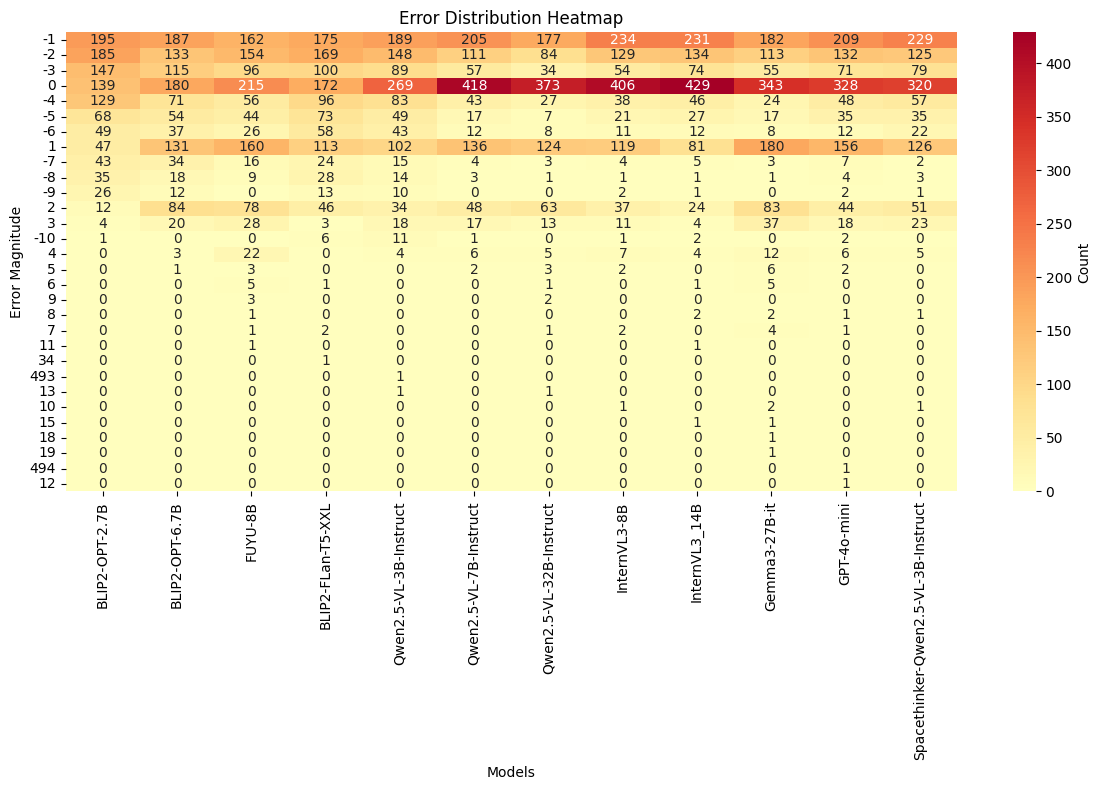

In [13]:
def plot_error_heatmap(model_results_dict):
    """Create a heatmap showing error distribution across categories."""
    plt.figure(figsize=(12, 8))

    # Prepare data for heatmap
    error_counts = {}
    for model, results in model_results_dict.items():
        errors = results['error_distribution']['error_distribution']
        # Count occurrences of each error value
        error_counts[model] = pd.Series(errors).value_counts().to_dict()
    
    # Convert to DataFrame
    error_df = pd.DataFrame(error_counts).fillna(0)
    
    sns.heatmap(error_df, cmap='RdYlBu_r', center=0, 
                annot=True, fmt='.0f',
                cbar_kws={'label': 'Count'})
    
    plt.title('Error Distribution Heatmap')
    plt.xlabel('Models')
    plt.ylabel('Error Magnitude')
    plt.tight_layout()

plot_error_heatmap(model_results)

In [14]:
# def plot_radar_metrics(model_results_dict):
#     """Create a radar plot comparing multiple metrics across models."""
#     metrics = ['MAE', 'MSE', 'RMSE', 'Accuracy']
#     angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    
#     fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
#     for model, results in model_results_dict.items():
#         values = [
#             results['overall_error_metrics']['MAE'],
#             results['overall_error_metrics']['MSE'],
#             results['overall_error_metrics']['RMSE'],
#             results['overall']
#         ]
#         # Normalize values for better visualization
#         values = [v/max(values) for v in values]
#         ax.plot(angles, values, label=model)
#         ax.fill(angles, values, alpha=0.25)
    
#     ax.set_xticks(angles)
#     ax.set_xticklabels(metrics)
#     ax.set_title('Model Performance Radar Plot')
#     plt.legend(bbox_to_anchor=(1.3, 0.3))
#     plt.tight_layout()

# plot_radar_metrics(model_results)

In [15]:
# def plot_error_bubbles(model_results_dict):
#     """Create a bubble plot showing error distribution."""
#     plt.figure(figsize=(12, 8))
    
#     for model, results in model_results_dict.items():
#         errors = results['error_distribution']['error_distribution']
#         error_counts = pd.Series(errors).value_counts()
        
#         plt.scatter(error_counts.index, 
#                    [model] * len(error_counts),
#                    s=error_counts.values * 100,
#                    alpha=0.6,
#                    label=model)
    
#     plt.title('Error Distribution Bubble Plot')
#     plt.xlabel('Error Magnitude')
#     plt.ylabel('Models')
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.tight_layout()

# plot_error_bubbles(model_results)

In [16]:
# # Error analysis using seaborn
# def plot_error_analysis(model_results_dict):
#     """Create alternative error analysis plots using seaborn."""
#     # Create a figure with multiple subplots
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
#     # 1. Violin Plot for Error Distribution
#     error_data = []
#     model_names = []
#     for model, results in model_results_dict.items():
#         errors = results['error_distribution']['error_distribution']
#         error_data.extend(errors)
#         model_names.extend([model] * len(errors))
    
#     error_df = pd.DataFrame({
#         'Error': error_data,
#         'Model': model_names
#     })
    
#     sns.violinplot(data=error_df, x='Model', y='Error', ax=ax1)
#     ax1.set_title('Error Distribution by Model')
#     ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
#     # 2. Box Plot for Error Metrics
#     metrics_data = []
#     for model, results in model_results_dict.items():
#         metrics = results['overall_error_metrics']
#         for metric, value in metrics.items():
#             if metric != 'category' and metric != 'sample_size':
#                 metrics_data.append({
#                     'Model': model,
#                     'Metric': metric,
#                     'Value': value
#                 })
    
#     metrics_df = pd.DataFrame(metrics_data)
#     sns.boxplot(data=metrics_df, x='Model', y='Value', hue='Metric', ax=ax2)
#     ax2.set_title('Error Metrics Distribution')
#     ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    
#     # 3. KDE Plot for Error Distribution
#     sns.kdeplot(data=error_df, x='Error', hue='Model', ax=ax3)
#     ax3.set_title('Error Distribution Density')
    
#     # 4. Swarm Plot for Error Distribution
#     sns.swarmplot(data=error_df, x='Model', y='Error', ax=ax4)
#     ax4.set_title('Error Distribution by Model')
#     ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
    
#     plt.tight_layout()
#     # plt.savefig('error_analysis_alternative.png', bbox_inches='tight', dpi=300)
#     # plt.close()

# plot_error_analysis(model_results)

In [17]:
# def plot_accuracy_analysis(model_results_dict):
#     """Create accuracy analysis plots."""
#     # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
#     # 1. Cumulative Accuracy Plot
#     plt.figure(figsize=(10, 6))
    
#     for model, results in model_results_dict.items():
#         off_by_n = results['off_by_n']
#         # Get the maximum N from the available keys
#         max_n = max([int(k.split('_')[-1]) for k in off_by_n.keys() if k.startswith('off_by_')])
#         tolerances = list(range(max_n + 1))
#         accuracies = [off_by_n[f'off_by_{i}'] for i in range(max_n + 1)]
        
#         plt.plot(tolerances, accuracies, marker='o', label=model)

#     # Add baseline markers
#     baseline_colors = ['darkred', 'darkred', 'darkred']  # Same color for all baselines
#     baseline_styles = ['--', ':', '-.']  # Different line styles
#     baseline_labels = ['Random Baseline', 'Off-by-1 Baseline', 'Off-by-2 Baseline']
#     baseline_values = [0.0909, 0.2562, 0.4050]  # Your baseline values
    
#     for value, style, label, color in zip(baseline_values, baseline_styles, baseline_labels, baseline_colors):
#         plt.axhline(y=value, color=color, linestyle=style, alpha=0.5, label=label)
    
#     plt.title('Cumulative Accuracy by Tolerance')
#     plt.xlabel('Tolerance (N)')
#     plt.ylabel('Cumulative Accuracy')
#     plt.grid(True, alpha=0.3)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     # plt.savefig('cumulative_accuracy.png', bbox_inches='tight', dpi=300)
#     # plt.close()
    
#     # 2. Accuracy Distribution by Category
#     plt.figure(figsize=(10, 6))
    
#     categories = ['Direct Recognition', 'Property Inference', 'Counterfactual']
#     x = np.arange(len(categories))
#     width = 0.8 / len(model_results_dict)
    
#     for i, (model, results) in enumerate(model_results_dict.items()):
#         accuracies = [results['question_type'][cat] for cat in categories]
#         plt.bar(x + i*width, accuracies, width, label=model)
    
#     plt.title('Accuracy Distribution by Question Type')
#     plt.xticks(x + width * (len(model_results_dict)-1)/2, categories)
#     plt.ylabel('Accuracy')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     # plt.savefig('accuracy_by_question_type.png', bbox_inches='tight', dpi=300)
#     # plt.close()

# plot_accuracy_analysis(model_results)

In [18]:
def plot_accuracy_analysis(model_results_dict, selected_models=None):
    """Create cumulative accuracy plot with customizations."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Choose models to plot (in order)
    if selected_models is None:
        # Default: plot all models
        selected_models = list(model_results_dict.keys())
    # Define marker styles for up to 4 models
    marker_styles = ['o', 's', '^', 'D', 'P', '*', 'X', 'v']
    # If more models than markers, cycle through
    marker_map = {model: marker_styles[i % len(marker_styles)] for i, model in enumerate(selected_models)}

    plt.figure(figsize=(10, 6))

    for model in selected_models:
        if model not in model_results_dict:
            continue
        results = model_results_dict[model]
        off_by_n = results['off_by_n']
        max_n = max([int(k.split('_')[-1]) for k in off_by_n.keys() if k.startswith('off_by_')])
        tolerances = list(range(max_n + 1))
        accuracies = [off_by_n[f'off_by_{i}'] * 100 for i in range(max_n + 1)]  # Convert to percentage

        plt.plot(
            tolerances, accuracies,
            marker=marker_map[model],
            label=model,
            linewidth=2,
            markersize=8
        )

    # Baseline markers
    baseline_colors = ['red', 'red', 'red']
    baseline_styles = ['--', ':', '-.']
    baseline_labels = ['Random Baseline', 'Off-by-1 Baseline', 'Off-by-2 Baseline']
    baseline_values = [0.0909, 0.2562, 0.4050]  # As fractions

    for value, style, label, color in zip(baseline_values, baseline_styles, baseline_labels, baseline_colors):
        plt.axhline(y=value * 100, color=color, linestyle=style, alpha=0.5, label=label)  # Convert to percentage

    plt.title('Cumulative Accuracy by Tolerance')
    plt.xlabel('Tolerance (N)')
    plt.ylabel('Cumulative Accuracy (%)')
    plt.ylim(0, 100)
    plt.xticks([0, 1, 2])
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # plt.show()
    plt.savefig('cumulative_accuracy.png', bbox_inches='tight', dpi=300)
    plt.close()

# Example usage:
# Only plot these models (change as needed)
selected_models = [
    # 'Qwen2.5-VL-7B-Instruct_fp16',
    # 'InternVL3-8B_fp16',
    # 'InternVL2.5-8B-MPO_fp16',
    'FUYU-8B',
    # 'Qwen2.5-VL-32B-Instruct',
    'InternVL3_14B',
    # 'Gemma3-27B-it',
    # 'GPT-4o-mini'
    # 'Gemini2_0Flash'
]
plot_accuracy_analysis(model_results, selected_models=selected_models)


Question Distribution by Property Category:
                   Count  Percentage
property_category                   
taxonomic            333       30.83
relational           283       26.20
physical             244       22.59
functional           220       20.37


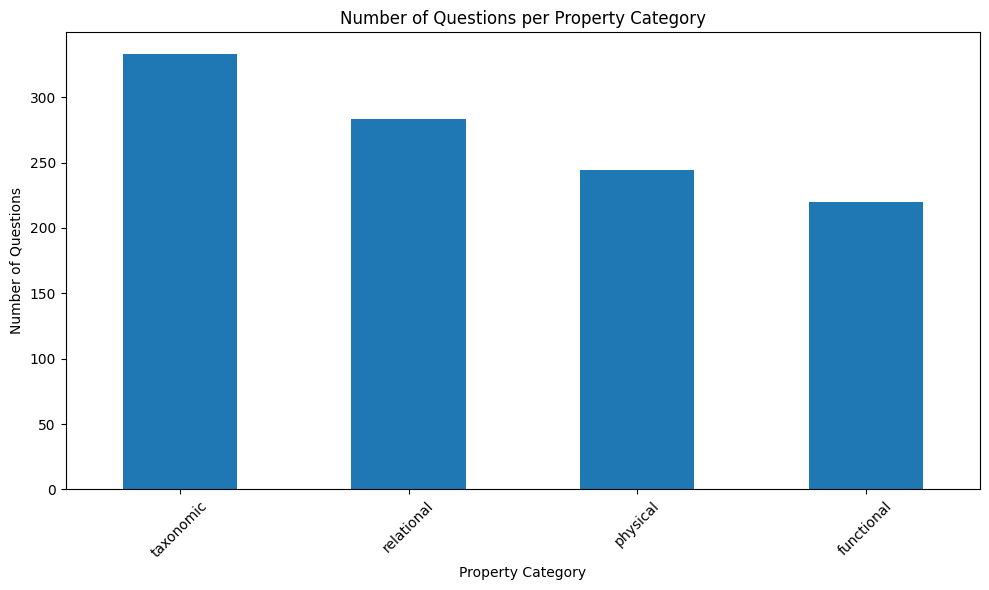

In [19]:
def analyze_question_distribution(results_file):
    """Analyze the distribution of questions across property categories."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Count questions per property category
    property_counts = df['property_category'].value_counts()
    
    # Calculate percentages
    property_percentages = (property_counts / len(df) * 100).round(2)
    
    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Count': property_counts,
        'Percentage': property_percentages
    })
    
    print("\nQuestion Distribution by Property Category:")
    print(summary_df)
    
    # Visualize the distribution
    plt.figure(figsize=(10, 6))
    property_counts.plot(kind='bar')
    plt.title('Number of Questions per Property Category')
    plt.xlabel('Property Category')
    plt.ylabel('Number of Questions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return summary_df

# Usage:
distribution = analyze_question_distribution('/var/scratch/ave303/OP_bench/ORBIT_results/InternVL3_results_8b.json')


Property Type Distribution by Question Type:
property_category   functional  physical  relational  taxonomic
question_category                                              
Counterfactual              72       115          71        102
Direct Recognition           0       129           0        231
Property Inference         148         0         212          0

Property Type Distribution by Question Type (Percentage):
property_category   functional  physical  relational  taxonomic
question_category                                              
Counterfactual           20.00     31.94       19.72      28.33
Direct Recognition        0.00     35.83        0.00      64.17
Property Inference       41.11      0.00       58.89       0.00


(property_category   functional  physical  relational  taxonomic
 question_category                                              
 Counterfactual              72       115          71        102
 Direct Recognition           0       129           0        231
 Property Inference         148         0         212          0,
 property_category   functional   physical  relational  taxonomic
 question_category                                               
 Counterfactual       20.000000  31.944444   19.722222  28.333333
 Direct Recognition    0.000000  35.833333    0.000000  64.166667
 Property Inference   41.111111   0.000000   58.888889   0.000000)

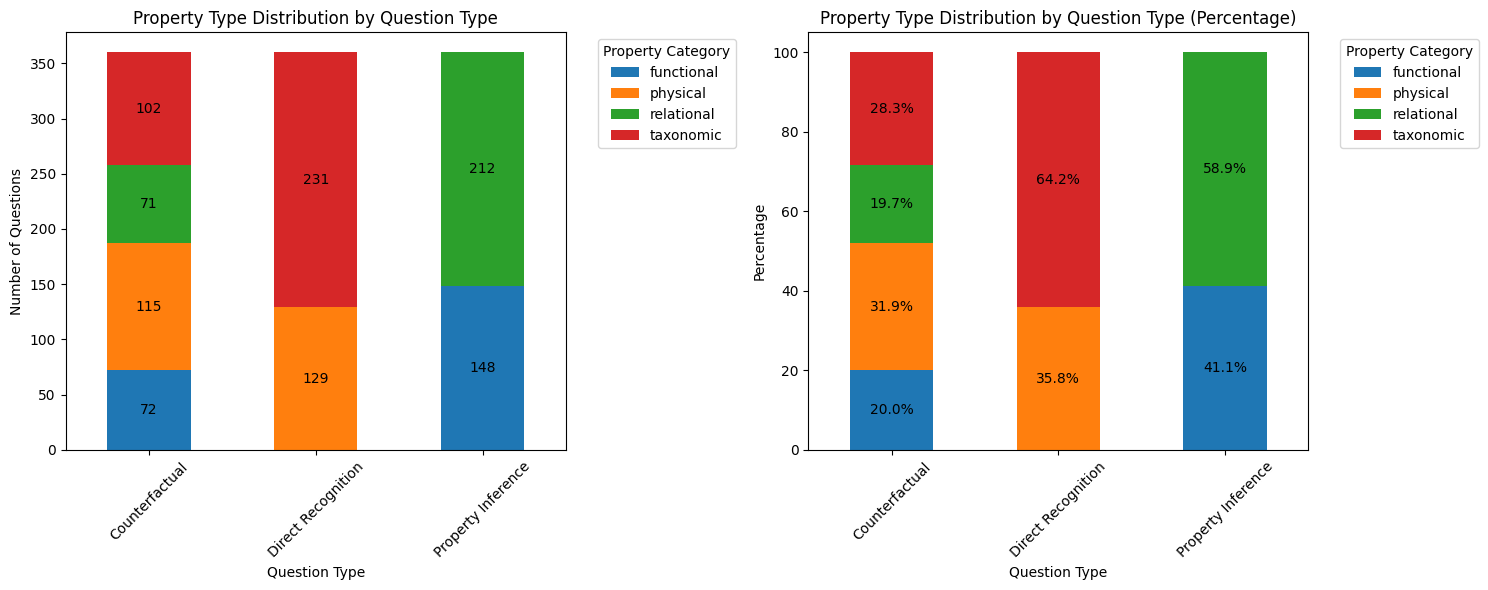

In [20]:
def plot_property_distribution_by_question_type(results_file):
    """Analyze and plot the distribution of property types across question types."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Create mapping from question_id to question category
    question_category_map = {
        'Q1': 'Direct Recognition',
        'Q2': 'Property Inference',
        'Q3': 'Counterfactual'
    }
    
    # Add question category column based on question_id
    df['question_category'] = df['question_id'].map(question_category_map)

    # Create a cross-tabulation of question types and property categories
    cross_tab = pd.crosstab(df['question_category'], df['property_category'])
    
    # Calculate percentages for each question type
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Stacked bar chart
    cross_tab.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_title('Property Type Distribution by Question Type')
    ax1.set_xlabel('Question Type')
    ax1.set_ylabel('Number of Questions')
    ax1.legend(title='Property Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)

    # Add count labels to the stacked bars
    for c in ax1.containers:
        labels = [f'{int(v)}' if v > 0 else '' for v in c.datavalues]
        ax1.bar_label(c, labels=labels, label_type='center')
    
    # 2. Stacked percentage bar chart
    cross_tab_pct.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Property Type Distribution by Question Type (Percentage)')
    ax2.set_xlabel('Question Type')
    ax2.set_ylabel('Percentage')
    ax2.legend(title='Property Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add percentage labels to the stacked bars
    for c in ax2.containers:
        labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
        ax2.bar_label(c, labels=labels, label_type='center')
    
    plt.tight_layout()
    # plt.savefig('property_distribution_by_question_type.png', bbox_inches='tight', dpi=300)
    # plt.close()

    # Print the numerical distribution
    print("\nProperty Type Distribution by Question Type:")
    print(cross_tab)
    print("\nProperty Type Distribution by Question Type (Percentage):")
    print(cross_tab_pct.round(2))
    
    return cross_tab, cross_tab_pct

plot_property_distribution_by_question_type('/var/scratch/ave303/OP_bench/ORBIT_results/InternVL3_results_8b.json')

In [21]:
def analyze_accuracy_by_property_and_question(results_file):
    """Analyze accuracy distribution across both property categories and question types."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Create mapping from question_id to question category
    question_category_map = {
        'Q1': 'Direct Recognition',
        'Q2': 'Property Inference',
        'Q3': 'Counterfactual'
    }
    
    # Add question category column based on question_id
    df['question_category'] = df['question_id'].map(question_category_map)
    
    # Calculate accuracy for each combination of question type and property category
    accuracy_data = []
    
    for q_type in df['question_category'].unique():
        for p_type in df['property_category'].unique():
            subset = df[(df['question_category'] == q_type) & (df['property_category'] == p_type)]
            if len(subset) > 0:
                correct = sum(subset['model_answer'] == subset['ground_truth'])
                total = len(subset)
                accuracy = correct / total if total > 0 else 0
                accuracy_data.append({
                    'Question Type': q_type,
                    'Property Category': p_type,
                    'Accuracy': accuracy,
                    'Count': total,
                    'Correct': correct
                })
    
    # Convert to DataFrame
    accuracy_df = pd.DataFrame(accuracy_data)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Create grouped bar plot
    sns.barplot(data=accuracy_df, 
                x='Question Type', 
                y='Accuracy', 
                hue='Property Category',
                palette='Set2')
    
    plt.title('Accuracy by Question Type and Property Category')
    plt.xlabel('Question Type')
    plt.ylabel('Accuracy')
    plt.legend(title='Property Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Add count annotations
    for i, row in accuracy_df.iterrows():
        plt.text(i % 3, row['Accuracy'], 
                f'n={row["Count"]}\n({row["Correct"]}/{row["Count"]})',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('accuracy_by_property_and_question.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Print detailed statistics
    print("\nDetailed Accuracy Analysis:")
    print("\nAccuracy by Question Type and Property Category:")
    print(accuracy_df.to_string(index=False))
    
    # Calculate weighted averages
    weighted_avg = accuracy_df.groupby('Question Type').apply(
        lambda x: sum(x['Accuracy'] * x['Count']) / sum(x['Count'])
    )
    print("\nWeighted Average Accuracy by Question Type:")
    print(weighted_avg)
    
    return accuracy_df

In [22]:
# accuracy_analysis1 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/InternVL2.5_results_8bMPO.json')

In [23]:
# accuracy_analysis2 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/InternVL3_results_8b.json')

In [24]:
# accuracy_analysis3 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/Qwen2.5-VL_7b_results.json')

In [25]:
# accuracy_analysis4 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/InternVL3_results_14b.json')

In [26]:
# accuracy_analysis5 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/Qwen2.5-VL_32b_results.json')

In [27]:
# accuracy_analysis6 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/Spacethinker_Qwen2.5-VL_3b_results.json')

In [28]:
accuracy_analysis7 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/ORBIT_results/Gemma3_27b_results.json')


Detailed Accuracy Analysis:

Accuracy by Question Type and Property Category:
     Question Type Property Category  Accuracy  Count  Correct
Direct Recognition          physical  0.255814    129       33
Direct Recognition         taxonomic  0.385281    231       89
Property Inference        functional  0.304054    148       45
Property Inference        relational  0.391509    212       83
    Counterfactual          physical  0.269565    115       31
    Counterfactual        functional  0.250000     72       18
    Counterfactual        relational  0.253521     71       18
    Counterfactual         taxonomic  0.254902    102       26

Weighted Average Accuracy by Question Type:
Question Type
Counterfactual        0.258333
Direct Recognition    0.338889
Property Inference    0.355556
dtype: float64


/tmp/ipykernel_2916267/2758041512.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = accuracy_df.groupby('Question Type').apply(


In [29]:
# accuracy_analysis8 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results.json')

In [30]:
# accuracy_analysis9 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results1.json')

In [31]:
# accuracy_analysis10 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results_1.json')

In [32]:
# accuracy_analysis11 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Qwen2.5-VL_3b_results.json')

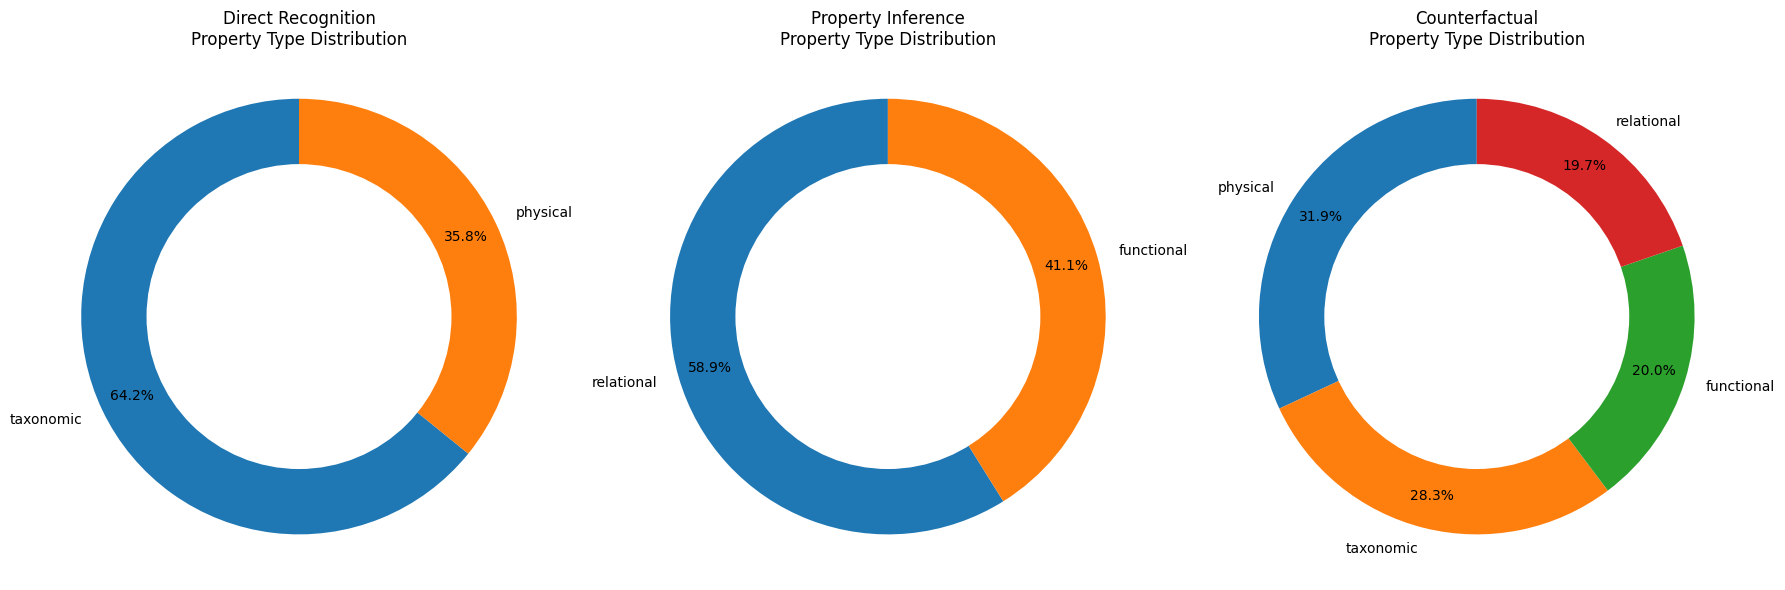

In [33]:
def plot_property_donut_by_question_type(results_file):
    """Plot donut charts of property type distribution for each question type."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Map question_id to question category
    question_category_map = {
        'Q1': 'Direct Recognition',
        'Q2': 'Property Inference',
        'Q3': 'Counterfactual'
    }
    df['question_category'] = df['question_id'].map(question_category_map)
    
    property_categories = df['property_category'].unique()
    question_types = df['question_category'].unique()
    
    fig, axes = plt.subplots(1, len(question_types), figsize=(6 * len(question_types), 6))
    if len(question_types) == 1:
        axes = [axes]
    
    for ax, qtype in zip(axes, question_types):
        counts = df[df['question_category'] == qtype]['property_category'].value_counts()
        labels = counts.index
        sizes = counts.values
        wedges, texts, autotexts = ax.pie(
            sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85
        )
        # Draw a circle at the center to make it a donut
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        ax.add_artist(centre_circle)
        ax.set_title(f"{qtype}\nProperty Type Distribution")
        ax.axis('equal')
    
    plt.tight_layout()
    plt.show()

plot_property_donut_by_question_type('/var/scratch/ave303/OP_bench/ORBIT_results/Gemma3_27b_results.json')

In [34]:
# def plot_nested_donut(results_file):
#     """Plot a nested donut chart for question type and property type composition."""
#     results = load_results(results_file)
#     df = pd.DataFrame(results)
    
#     # Map question_id to question category
#     question_category_map = {
#         'Q1': 'Direct Recognition',
#         'Q2': 'Property Inference',
#         'Q3': 'Counterfactual'
#     }
#     df['question_category'] = df['question_id'].map(question_category_map)
    
#     # Outer ring: property_category, Inner ring: question_category
#     outer_labels = []
#     outer_sizes = []
#     inner_labels = []
#     inner_sizes = []
    
#     for qtype in df['question_category'].unique():
#         subdf = df[df['question_category'] == qtype]
#         inner_labels.append(qtype)
#         inner_sizes.append(len(subdf))
#         for ptype, count in subdf['property_category'].value_counts().items():
#             outer_labels.append(f"{qtype}\n{ptype}")
#             outer_sizes.append(count)
    
#     # Colors
#     cmap = plt.get_cmap("tab20c")
#     outer_colors = cmap(np.arange(len(outer_labels)))
#     inner_colors = cmap(np.arange(len(inner_labels))*4)
    
#     fig, ax = plt.subplots(figsize=(8,8))
#     ax.pie(inner_sizes, labels=inner_labels, radius=1, colors=inner_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
#     ax.pie(outer_sizes, labels=outer_labels, radius=1.3, colors=outer_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
#     ax.set(aspect="equal")
#     plt.title("Nested Donut: Question Type and Property Type Composition")
#     plt.show()

# plot_nested_donut('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [35]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_nested_donut_with_labels(results_file):
#     results = load_results(results_file)
#     df = pd.DataFrame(results)
    
#     question_category_map = {
#         'Q1': 'Direct Recognition',
#         'Q2': 'Property Inference',
#         'Q3': 'Counterfactual'
#     }
#     df['question_category'] = df['question_id'].map(question_category_map)
    
#     # Prepare data
#     inner_labels = []
#     inner_sizes = []
#     outer_labels = []
#     outer_sizes = []
#     outer_pct_labels = []
#     color_base = plt.get_cmap("tab10")
#     color_light = plt.get_cmap("Pastel1")
#     color_map = {}
    
#     for i, qtype in enumerate(df['question_category'].unique()):
#         subdf = df[df['question_category'] == qtype]
#         inner_labels.append(qtype)
#         inner_sizes.append(len(subdf))
#         color_map[qtype] = color_base(i)
#         for j, (ptype, count) in enumerate(subdf['property_category'].value_counts().items()):
#             outer_labels.append(f"{ptype}")
#             outer_sizes.append(count)
#             pct = 100 * count / len(subdf)
#             outer_pct_labels.append(f"{count} ({pct:.1f}%)")
    
#     # Colors: inner ring solid, outer ring lighter
#     inner_colors = [color_map[qtype] for qtype in inner_labels]
#     outer_colors = []
#     for qtype in df['question_category'].unique():
#         c = color_map[qtype]
#         # Make lighter for outer ring
#         outer_colors.extend([tuple(np.array(c)*0.6 + 0.4) for _ in df[df['question_category']==qtype]['property_category'].value_counts()])
    
#     fig, ax = plt.subplots(figsize=(9, 7))
#     wedges1, _ = ax.pie(inner_sizes, labels=inner_labels, radius=1, colors=inner_colors, 
#                         wedgeprops=dict(width=0.3, edgecolor='w'), labeldistance=0.7)
#     wedges2, _ = ax.pie(outer_sizes, labels=outer_labels, radius=1.3, colors=outer_colors, 
#                         wedgeprops=dict(width=0.3, edgecolor='w'), labeldistance=1.05)
    
#     # Add value labels to outer wedges
#     for i, w in enumerate(wedges2):
#         ang = (w.theta2 - w.theta1)/2. + w.theta1
#         y = np.sin(np.deg2rad(ang))
#         x = np.cos(np.deg2rad(ang))
#         horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#         ax.annotate(outer_pct_labels[i], xy=(x*1.45, y*1.45), ha=horizontalalignment, va='center', fontsize=10, fontweight='bold')
    
#     # plt.title("Nested Donut: Question Type and Property Type Composition")
#     plt.tight_layout()
#     plt.show()

# plot_nested_donut_with_labels('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [36]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_nested_donut_with_inside_labels(results_file):
#     results = load_results(results_file)
#     df = pd.DataFrame(results)
    
#     question_category_map = {
#         'Q1': 'Direct Recognition',
#         'Q2': 'Property Inference',
#         'Q3': 'Counterfactual'
#     }
#     df['question_category'] = df['question_id'].map(question_category_map)
    
#     # Prepare data
#     inner_labels = []
#     inner_sizes = []
#     outer_labels = []
#     outer_sizes = []
#     outer_pct_labels = []
#     color_base = plt.get_cmap("tab10")
#     color_map = {}
    
#     for i, qtype in enumerate(df['question_category'].unique()):
#         subdf = df[df['question_category'] == qtype]
#         inner_labels.append(qtype)
#         inner_sizes.append(len(subdf))
#         color_map[qtype] = color_base(i)
#         for ptype, count in subdf['property_category'].value_counts().items():
#             outer_labels.append(ptype)
#             outer_sizes.append(count)
#             pct = 100 * count / len(subdf)
#             outer_pct_labels.append(f"{pct:.1f}%")
    
#     # Colors: inner ring solid, outer ring lighter
#     inner_colors = [color_map[qtype] for qtype in inner_labels]
#     outer_colors = []
#     for qtype in df['question_category'].unique():
#         c = color_map[qtype]
#         # Make lighter for outer ring
#         outer_colors.extend([tuple(np.array(c)*0.6 + 0.4) for _ in df[df['question_category']==qtype]['property_category'].value_counts()])
    
#     fig, ax = plt.subplots(figsize=(8, 7))
#     # Make the rings wider and the center smaller
#     wedges1, _ = ax.pie(
#         inner_sizes, labels=inner_labels, radius=1, colors=inner_colors, 
#         wedgeprops=dict(width=0.45, edgecolor='w'), labeldistance=0.5
#     )
#     wedges2, _ = ax.pie(
#         outer_sizes, labels=None, radius=1.45, colors=outer_colors, 
#         wedgeprops=dict(width=0.45, edgecolor='w')
#     )
    
#     # Place percentage labels inside the outer wedges
#     for i, w in enumerate(wedges2):
#         ang = (w.theta2 - w.theta1)/2. + w.theta1
#         y = np.sin(np.deg2rad(ang))
#         x = np.cos(np.deg2rad(ang))
#         ax.text(
#             x*1.25, y*1.25, outer_pct_labels[i],
#             ha='center', va='center', fontsize=11, fontweight='bold', color='black'
#         )
    
#     plt.title("Nested Donut: Question Type and Property Type Composition")
#     plt.tight_layout()
#     plt.show()

# plot_nested_donut_with_inside_labels('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_nested_donut_with_all_labels(results_file):
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    question_category_map = {
        'Q1': 'Direct \nRecognition',
        'Q2': 'Property \nInference',
        'Q3': 'Counterfactual'
    }
    df['question_category'] = df['question_id'].map(question_category_map)
    
    # Prepare data
    inner_labels = []
    inner_sizes = []
    outer_labels = []
    outer_sizes = []
    outer_pct_labels = []
    color_base = plt.get_cmap("tab10")
    color_map = {}
    outer_label_map = []
    
    for i, qtype in enumerate(df['question_category'].unique()):
        subdf = df[df['question_category'] == qtype]
        inner_labels.append(qtype)
        inner_sizes.append(len(subdf))
        color_map[qtype] = color_base(i)
        for ptype, count in subdf['property_category'].value_counts().items():
            outer_labels.append(ptype)
            outer_sizes.append(count)
            pct = 100 * count / len(subdf)
            outer_pct_labels.append(f"{ptype}\n{pct:.1f}%")
            outer_label_map.append(qtype)
    
    # Colors: inner ring solid, outer ring lighter
    inner_colors = [color_map[qtype] for qtype in inner_labels]
    outer_colors = []
    for qtype in df['question_category'].unique():
        c = color_map[qtype]
        # Make lighter for outer ring
        outer_colors.extend([tuple(np.array(c)*0.6 + 0.4) for _ in df[df['question_category']==qtype]['property_category'].value_counts()])
    
    fig, ax = plt.subplots(figsize=(8, 7))
    # Make the rings wider and the center smaller
    wedges1, _ = ax.pie(
        inner_sizes, labels=None, radius=1, colors=inner_colors, 
        wedgeprops=dict(width=0.45, edgecolor='w')
    )
    wedges2, _ = ax.pie(
        outer_sizes, labels=None, radius=1.45, colors=outer_colors, 
        wedgeprops=dict(width=0.45, edgecolor='w')
    )
    
    # Place inner ring labels (question types)
    for i, w in enumerate(wedges1):
        ang = (w.theta2 - w.theta1)/2. + w.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        ax.text(
            x*0.75, y*0.75, inner_labels[i],
            ha='center', va='center', fontsize=9.5, fontweight='bold', color='white'
        )
    
    # Place outer ring labels (property type + percentage)
    for i, w in enumerate(wedges2):
        ang = (w.theta2 - w.theta1)/2. + w.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        ax.text(
            x*1.22, y*1.22, outer_pct_labels[i],
            ha='center', va='center', fontsize=8.5, fontweight='bold', color='black'
        )
    
    # plt.title("Nested Donut: Question Type and Property Type Composition")
    ax.text(0, 0, "ORBIT\nComposition", ha='center', va='center', fontsize=15, fontweight='bold', color='black')
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'benchmark_composition.png', bbox_inches='tight', dpi=300)
    plt.close()

plot_nested_donut_with_all_labels('/var/scratch/ave303/OP_bench/ORBIT_results/Gemma3_27b_results.json')

In [38]:
def plot_ground_truth_distribution(results_file):
    """Plot the distribution of ground truth counts from 0-10."""
    results = load_results(results_file)
    df = pd.DataFrame(results)

    # Convert ground_truth to integer
    df['ground_truth'] = df['ground_truth'].astype(int)

    # Count occurrences of each ground truth value
    gt_counts = df['ground_truth'].value_counts().sort_index()
    
    # Create a complete range from 0-10, filling missing values with 0
    complete_range = pd.Series(index=range(11), data=0)
    complete_range.update(gt_counts)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(complete_range.index, complete_range.values, 
                   color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # Y-axis: whole numbers only
    plt.gca().yaxis.get_major_locator().set_params(integer=True)
    
    plt.title('Distribution of Ground Truth Counts (0-10)', fontsize=14, fontweight='bold')
    plt.xlabel('Ground Truth Count', fontsize=12)
    plt.ylabel('Number of Questions', fontsize=12)
    plt.xticks(range(11))
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add total count annotation
    total_questions = len(df)
    plt.text(0.02, 0.98, f'Total Questions: {total_questions}', 
             transform=plt.gca().transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'Ground_truth_dist.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Print the numerical distribution
    print("\nGround Truth Count Distribution:")
    print("Count | Number of Questions | Percentage")
    print("-" * 40)
    for count in range(11):
        num_questions = complete_range[count]
        percentage = (num_questions / total_questions) * 100
        print(f"{count:5d} | {num_questions:18d} | {percentage:8.1f}%")
    
    return complete_range

# Usage example:
plot_ground_truth_distribution('/var/scratch/ave303/OP_bench/ORBIT_results/Gemma3_27b_results.json')


Ground Truth Count Distribution:
Count | Number of Questions | Percentage
----------------------------------------
    0 |                 23 |      2.1%
    1 |                124 |     11.5%
    2 |                198 |     18.3%
    3 |                192 |     17.8%
    4 |                172 |     15.9%
    5 |                123 |     11.4%
    6 |                 90 |      8.3%
    7 |                 45 |      4.2%
    8 |                 50 |      4.6%
    9 |                 34 |      3.1%
   10 |                 29 |      2.7%


0      23
1     124
2     198
3     192
4     172
5     123
6      90
7      45
8      50
9      34
10     29
dtype: int64

In [39]:
import json
import matplotlib.pyplot as plt

def count_consistent_outputs(results_file, values_to_check):
    """Count how many times each value appears in the 'model_answer' field."""
    with open(results_file, 'r') as f:
        data = json.load(f)
    counts = {str(v): 0 for v in values_to_check}
    for entry in data:
        model_answer = str(entry.get('model_answer', '')).strip()
        for v in values_to_check:
            if model_answer == str(v):
                counts[str(v)] += 1
    return counts

def plot_consistent_output_distribution_from_json(model_files, model_value_map):
    # Color map for values
    value_color_map = {
        '1': ("#a6cee3", "#1f78b4"),  # light blue, dark blue
        '3': ("#b2df8a", "#33a02c"),  # light green, dark green
        '0': ("#fdbf6f", "#ff7f00")   # light orange, dark orange
    }
    bar_labels = []
    bar_heights = []
    bar_colors = []
    bar_edgecolors = []
    legend_handles = {}
    x_positions = []
    xpos = 0

    for model, (file, values) in model_value_map.items():
        counts = count_consistent_outputs(file, values)
        for v in values:
            v_str = str(v)
            bar_labels.append(model if len(values) == 1 else f"{model}\n({v})")
            bar_heights.append(counts[v_str])
            color, edgecolor = value_color_map[v_str]
            bar_colors.append(color)
            bar_edgecolors.append(edgecolor)
            if v_str not in legend_handles:
                legend_handles[v_str] = plt.Rectangle((0,0),1,1,fc=color,ec=edgecolor)
            x_positions.append(xpos)
            xpos += 1

    plt.figure(figsize=(8, 6))
    bars = plt.bar(x_positions, bar_heights, color=bar_colors, edgecolor=bar_edgecolors, width=0.6)
    plt.xticks(x_positions, bar_labels, fontsize=12)
    plt.ylabel("Number of Questions", fontsize=13)
    plt.xlabel("Models", fontsize=13)
    plt.title("BLIP2 series Inductive Bias", fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # Legend
    plt.legend([legend_handles[v] for v in legend_handles],
               [f"Output value = {v}" for v in legend_handles],
               title="Consistent Output Value", loc='upper right')

    plt.tight_layout()
    # plt.show()
    plt.savefig(f'BLIP2_inductive_bias.png', bbox_inches='tight', dpi=300)
    plt.close()

# Example usage:
model_value_map = {
    "BLIP2-Flan-T5-XXL": ("/var/scratch/ave303/OP_bench/ORBIT_results/blip2-flan-t5-xxl_results.json", [0]),
    "BLIP2-OPT-2.7B": ("/var/scratch/ave303/OP_bench/ORBIT_results/blip2-opt-2.7b_results.json", [1]),
    "BLIP2-OPT-6.7B": ("/var/scratch/ave303/OP_bench/ORBIT_results/blip2-opt-6.7b_results.json", [1, 3])
}
plot_consistent_output_distribution_from_json(model_value_map, model_value_map)

In [40]:
# %pip install plotly
# %pip install umap-learn


In [41]:
# # Import required libraries
# from sklearn.manifold import TSNE
# import umap.umap_ as umap
# from sentence_transformers import SentenceTransformer
# # import plotly.express as px

# def analyze_error_clusters(predictions, ground_truths, questions, model_name='all-MiniLM-L6-v2'):
#     """
#     Analyze error patterns using t-SNE and UMAP clustering on question embeddings.
    
#     Args:
#         predictions: List of predicted counts
#         ground_truths: List of ground truth counts
#         questions: List of questions
#         model_name: Name of the sentence transformer model to use
#     """
#     # Convert to numeric values
#     preds = [int(str(p)) for p in predictions]
#     truths = [int(str(g)) for g in ground_truths]
    
#     # Find wrong answers
#     wrong_indices = [i for i, (p, t) in enumerate(zip(preds, truths)) if p != t]
#     wrong_questions = [questions[i] for i in wrong_indices]
#     error_magnitudes = [p - t for i, (p, t) in enumerate(zip(preds, truths)) if i in wrong_indices]
    
#     print(f"Number of wrong answers: {len(wrong_questions)}")
    
#     # Get embeddings for wrong questions
#     print("Generating embeddings...")
#     model = SentenceTransformer(model_name)
#     embeddings = model.encode(wrong_questions)
    
#     # Apply t-SNE
#     print("Applying t-SNE...")
#     tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
#     tsne_results = tsne.fit_transform(embeddings)
    
#     # Apply UMAP
#     print("Applying UMAP...")
#     reducer = umap.UMAP(random_state=42, n_neighbors=min(15, len(embeddings)-1))
#     umap_results = reducer.fit_transform(embeddings)
    
#     # Create plots
#     plt.figure(figsize=(15, 6))

#     # t-SNE plot
#     plt.subplot(1, 2, 1)
#     scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
#                          c=error_magnitudes, cmap='RdBu', alpha=0.6)
#     plt.colorbar(scatter, label='Error Magnitude')
#     plt.title('t-SNE Clustering of Wrong Answers')
#     plt.xlabel('t-SNE 1')
#     plt.ylabel('t-SNE 2')
    
#     # UMAP plot
#     plt.subplot(1, 2, 2)
#     scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], 
#                          c=error_magnitudes, cmap='RdBu', alpha=0.6)
#     plt.colorbar(scatter, label='Error Magnitude')
#     plt.title('UMAP Clustering of Wrong Answers')
#     plt.xlabel('UMAP 1')
#     plt.ylabel('UMAP 2')
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print some statistics about the errors
#     print("\nError Statistics:")
#     print(f"Mean error magnitude: {np.mean(error_magnitudes):.2f}")
#     print(f"Std error magnitude: {np.std(error_magnitudes):.2f}")
#     print(f"Min error: {min(error_magnitudes)}")
#     print(f"Max error: {max(error_magnitudes)}")
    
#     # Return the results for further analysis if needed
#     return {
#         'tsne_results': tsne_results,
#         'umap_results': umap_results,
#         'error_magnitudes': error_magnitudes,
#         'wrong_questions': wrong_questions
#     }

# # Example usage:
# # fig_tsne, fig_umap = analyze_error_clusters(predictions, ground_truths, questions)
# # fig_tsne.show()
# # fig_umap.show()

# for model_name, file_path in result_files.items():
#     if Path(file_path).exists():
#         print(f"\nAnalyzing {model_name}...")
#         results = load_results(file_path)
#         df = pd.DataFrame(results)
#         predictions = df['model_answer']
#         ground_truths = df['ground_truth']
#         questions = df['question']
#         outputs = analyze_error_clusters(predictions, ground_truths, questions)
#         # results = analyze_results(file_path, model_name)
#         # model_results[model_name] = results
#         # plot_results(results, model_name)
#         # fig_tsne.show()
#         # fig_umap.show()
        